In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Model, Sequential
import pandas as pd
df=pd.read_csv(r".\dataset\train.csv")
classes_list = df['target'].unique().tolist()
print(classes_list)
print(df.target.value_counts())
df.head()

C:\Users\Dell\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Dell\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Dell\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Dell\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (

['manipuri', 'bharatanatyam', 'odissi', 'kathakali', 'kathak', 'sattriya', 'kuchipudi', 'mohiniyattam']
mohiniyattam     50
odissi           49
bharatanatyam    47
kathakali        47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: target, dtype: int64


,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [2]:
df_test =pd.read_csv(r".\dataset\test.csv")
df_test.head()

,Image
0,508.jpg
1,246.jpg
2,473.jpg
3,485.jpg
4,128.jpg


Data Augmentation:-
Image Data Generator changes the differnt size images to the input size.
Normalize images while loading them.
Create augmented images in the memory.
Label them based on the labels in the dataframe (since we are using flow from dataframe)

In [3]:
datagen=ImageDataGenerator(rescale=1./255,shear_range=0.20,
                                   zoom_range=0.20,validation_split=0.2,
                                   horizontal_flip=True)

path = 'C:/Users/Dell/Desktop/Dance Dataset CNN/dataset/'
train_generator=datagen.flow_from_dataframe(dataframe=df, subset="training",has_ext=True,
                                            directory=path+"train", interpolation="nearest",validate_filenames=False,
                                            x_col="Image", y_col="target",color_mode="rgb",shuffle=True, classes = classes_list,
                                            class_mode="categorical", target_size=(128,128), batch_size=32)

valid_generator=datagen.flow_from_dataframe(dataframe=df, subset="validation",has_ext=True,
                                            directory=path+"train", interpolation="nearest",validate_filenames=False,
                                            x_col="Image", y_col="target",color_mode="rgb",shuffle=True, classes = classes_list,
                                            class_mode="categorical", target_size=(128,128), batch_size=32)


Found 292 non-validated image filenames belonging to 8 classes.
Found 72 non-validated image filenames belonging to 8 classes.


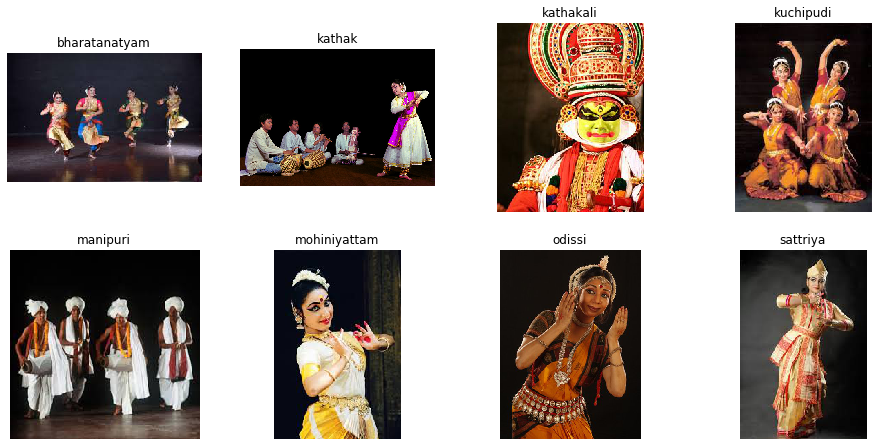

In [5]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os
nrows = 4
ncols = 4

pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=4

next_pix = [(os.path.join(path+'train', fname) , name)
                for fname,name in (zip(df.groupby('target').first().Image.values,df.groupby('target').first().index))]

for i, img_path in enumerate(next_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path[0])
    plt.imshow(img)
    plt.title(img_path[1])

plt.show()


In [8]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

IMAGE_SIZE = [224, 224]
# add preprocessing layer to the fromt of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #pooling='max')

58892288/58889256 [==============================] - 286s 5us/step


VGG-19 is a convolutional neural network which is 19 layers deep. It's pretrained version of the network has trained on more than a million images from the ImageNet database. This network is trained on images with an input size of 224-by-224. By adding few more layers to this pretrained model, we can use it for classification of the various dance forms. As, pretrained model has already extracted out the edges and important features from millions of images, so it can classify images with much higher accuracy.

In [9]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [10]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(1024, activation = 'relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.20)(x)
prediction = Dense(8, activation='softmax')(x)

In [11]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [12]:
# view the structure of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Set a Learning Rate Annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [ ]:
history = model.fit_generator(train_generator,
        validation_data = test_generator,
        epochs = 100,
        steps_per_epoch = len(train_generator),
        validation_steps = len(test_generator),
        callbacks = [learning_rate_reduction]
)

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss1')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AvvVal_acc1')

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')